In [1]:
from uk_covid19 import Cov19API
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

## UK Covid Impact on Sales and Closures

### Objective

The purpose of the notebook is to do ad-hoc correlation analysis between a company sales vs a set of UK covid metrics and Google mobility data

### Approach

* **1. Ingest data** - get UK Covid data from one of the sources below
* **2. Clean data** - clean data - remove empty columns and rows containging NaNs
* **3. Merge data sets** - merge UK Covid data with company sales data
* **4. Correlations** - compute and visualise correlation matrix
* **5. Pairwise correlations** - compute and visualise correlation matrix

### Resources
- [UK Covid Download](https://coronavirus.data.gov.uk/details/download) - limited to 5 metrics only, hard to automate, not fit for purpose
- [UK Covid API](https://coronavirus.data.gov.uk/details/developers-guide) - JSON API (maybe richer than SDK below)
- [UK Covid Python SDK](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk) - Python SDK wrapper around JSON API
- [Interactive Map](https://coronavirus.data.gov.uk/details/interactive-map) - could be potentially used for inspiration for visualisation

### Metrics
- [UK Covid Metrics](https://coronavirus.data.gov.uk/details/developers-guide#structure-metrics) - partial lists, documentation not well maintained
- **Cumulative vs Incremental** - we will use metrics tagged with *new* (incremental) rather than *cum* (cumulative), as sales / closures are measured on incremental, not on cumulative basis



## 1. Read in pre-processed data

In [3]:
sales_path = 'data/sales_channel_region.csv'
sales_df = pd.read_csv(sales_path)
sales_df

,takeaway,delivery,takeaway_other,takeaway_other_2,business_date,ons_region_code,ons_region_name
0,NaN,NaN,0.00,NaN,2021-02-14,E12000005,West Midlands
1,NaN,NaN,0.00,NaN,2021-02-14,S99999999,(pseudo) Scotland
2,NaN,NaN,0.00,NaN,2021-02-14,E12000003,Yorkshire and The Humber
3,NaN,NaN,0.00,NaN,2021-02-14,E12000002,North West
4,NaN,NaN,0.00,NaN,2021-02-14,E12000006,East of England
...,...,...,...,...,...,...,...
541,4853.58,8644.77,-7460.17,3668.98,2021-01-01,NaN,NaN
542,67895.23,87751.57,-83456.29,63599.95,2021-01-01,E12000002,North West
543,45580.54,64166.45,-60910.07,42324.16,2021-01-01,E12000005,West Midlands
544,96778.28,388238.02,-369296.92,77837.18,2021-01-01,E12000007,London


In [4]:
region_area_type = [
    "areaType=region"
]
metrics = {
    "date": "date",
    "areaName": "areaName",
    "areaCode": "areaCode",
    "newCasesByPublishDate": "newCasesByPublishDate",
    "newDeaths28DaysByPublishDate": "newDeaths28DaysByPublishDate",
    "newDeathsByDeathDate": "newDeathsByDeathDate",
   
}

region_api = Cov19API(
    filters=region_area_type,
    structure=metrics
)

region_df = region_api.get_dataframe()

# merge the data sets
sales_covid = pd.merge(region_df, sales_df, left_on=['date', 'areaCode'], 
                       right_on=['business_date', 'ons_region_code'])
sales_covid['areaName'].value_counts()

West Midlands               42
East of England             42
South West                  42
North East                  42
South East                  42
North West                  42
East Midlands               42
London                      42
Yorkshire and The Humber    42
Name: areaName, dtype: int64

In [5]:
mobility_path = 'data/2020_GB_Region_Mobility_Report.csv'
mobility_df = pd.read_csv(mobility_path)
mobility_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
1,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
3,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
4,GB,United Kingdom,NaN,NaN,NaN,NaN,NaN,2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0


In [6]:
mobility_df['sub_region_1'].value_counts()

Greater London          11662
Kent                     4450
Lancashire               4438
Essex                    4437
Hampshire                4101
                        ...  
Clackmannanshire          318
Rutland                   293
Na h-Eileanan an Iar      252
Shetland Islands          238
Orkney                    236
Name: sub_region_1, Length: 151, dtype: int64

## 4. Compute and visualise correlation matrix

In [7]:
sales_covid.corr()

,newCasesByPublishDate,newDeaths28DaysByPublishDate,newDeathsByDeathDate,takeaway,delivery,takeaway_other,takeaway_other_2
newCasesByPublishDate,1.000000,0.410053,0.607134,0.477521,0.584756,-0.593304,0.433113
newDeaths28DaysByPublishDate,0.410053,1.000000,0.761866,0.472821,0.423280,-0.438052,0.462270
newDeathsByDeathDate,0.607134,0.761866,1.000000,0.536410,0.486232,-0.494535,0.520989
takeaway,0.477521,0.472821,0.536410,1.000000,0.714921,-0.711663,0.990783
delivery,0.584756,0.423280,0.486232,0.714921,1.000000,-0.999836,0.620213
takeaway_other,-0.593304,-0.438052,-0.494535,-0.711663,-0.999836,1.000000,-0.617466
takeaway_other_2,0.433113,0.462270,0.520989,0.990783,0.620213,-0.617466,1.000000


<AxesSubplot:>

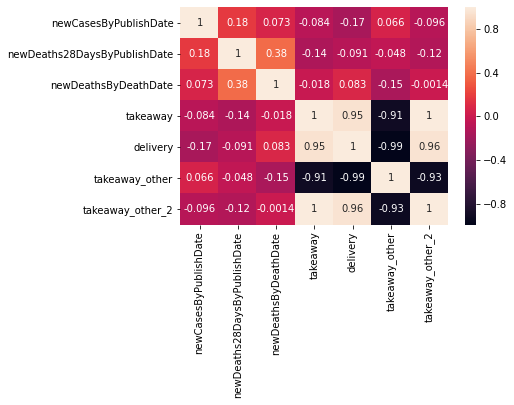

In [8]:
sns.heatmap(sales_covid[sales_covid['areaName']=='Yorkshire and The Humber'].corr(), annot=True)

<AxesSubplot:>

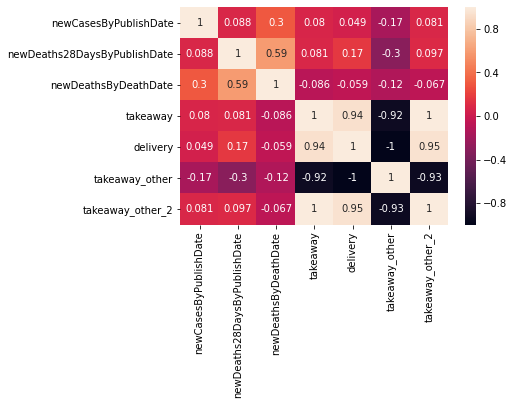

In [9]:
sns.heatmap(sales_covid[sales_covid['areaName']=='South East'].corr(), annot=True)

<AxesSubplot:>

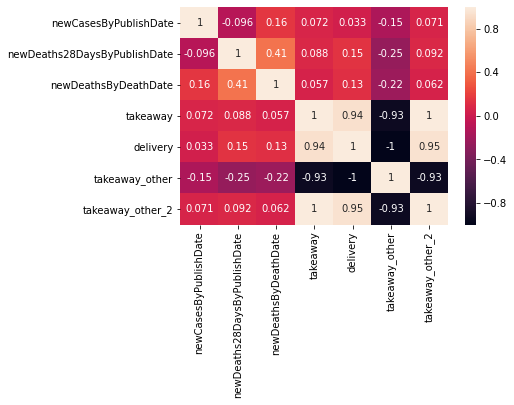

In [10]:
sns.heatmap(sales_covid[sales_covid['areaName']=='West Midlands'].corr(), annot=True)

<AxesSubplot:>

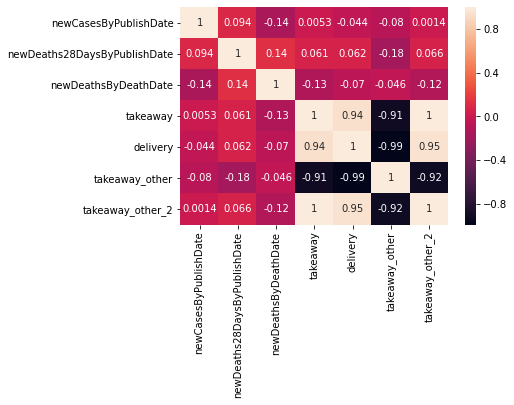

In [11]:
sns.heatmap(sales_covid[sales_covid['areaName']=='North East'].corr(), annot=True)

<AxesSubplot:>

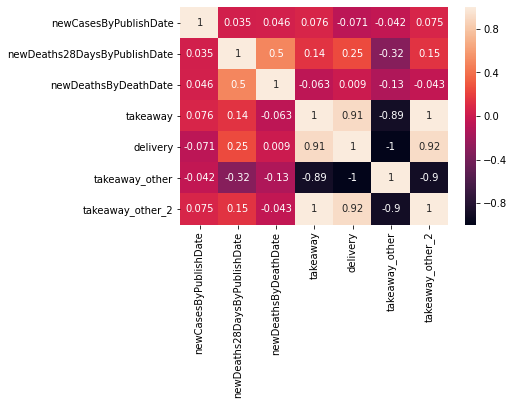

In [12]:
sns.heatmap(sales_covid[sales_covid['areaName']=='East Midlands'].corr(), annot=True)

<AxesSubplot:>

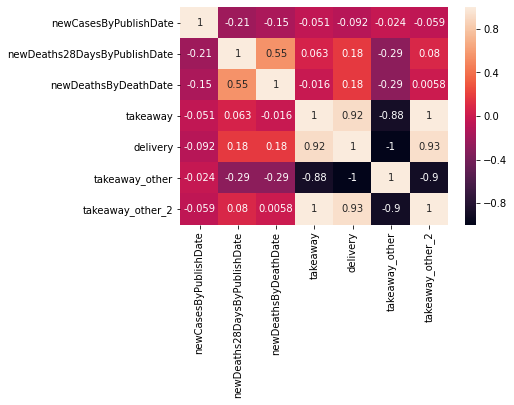

In [13]:
sns.heatmap(sales_covid[sales_covid['areaName']=='South West'].corr(), annot=True)

<AxesSubplot:>

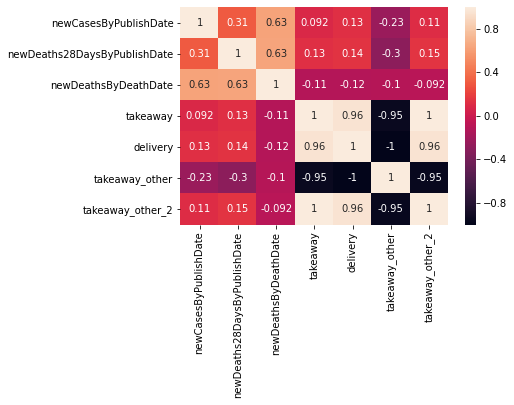

In [14]:
sns.heatmap(sales_covid[sales_covid['areaName']=='London'].corr(), annot=True)

<AxesSubplot:>

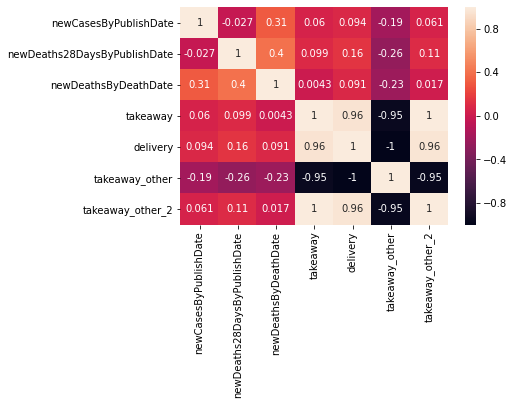

In [15]:
sns.heatmap(sales_covid[sales_covid['areaName']=='East of England'].corr(), annot=True)

<AxesSubplot:>

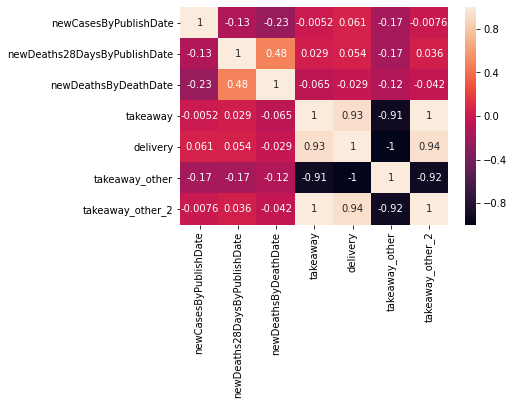

In [16]:
sns.heatmap(sales_covid[sales_covid['areaName']=='North West'].corr(), annot=True)

## 5. Plot pairwise correlations

KeyError: 'retail_and_recreation'

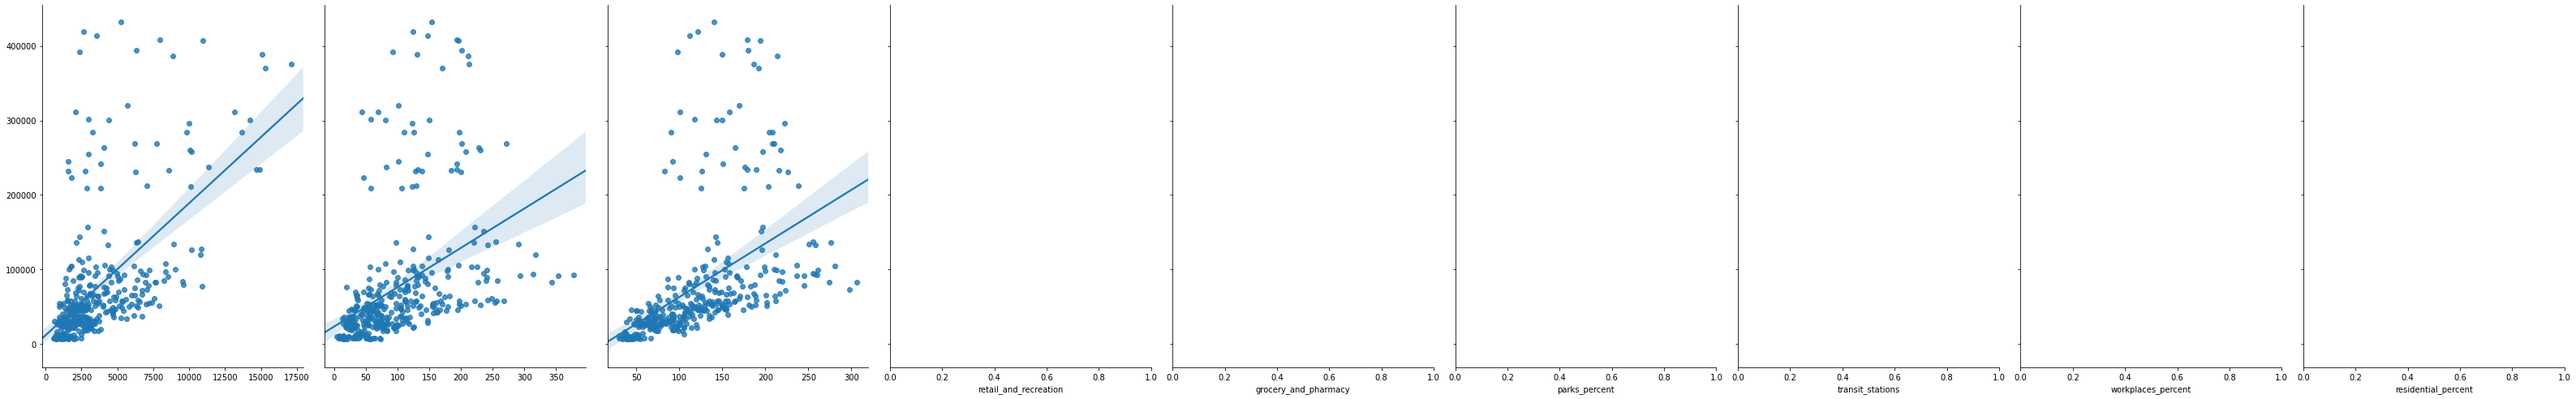

In [21]:
sns.pairplot(sales_covid, x_vars=['newCasesByPublishDate', 'newDeaths28DaysByPublishDate',
                           'newDeathsByDeathDate', 
                           'retail_and_recreation', 'grocery_and_pharmacy', 'parks_percent',
                           'transit_stations', 'workplaces_percent', 'residential_percent'], 
             y_vars='delivery', height=7, aspect=0.7, kind='reg');

In [ ]:
sm_df

,date,sales,newCasesByPublishDate,newDeaths28DaysByPublishDate,newDeathsByDeathDate,change_new_cases,change_new_cases_28,country_region_code,country_region,sub_region_1,retail_and_recreation,grocery_and_pharmacy,parks_percent,transit_stations,workplaces_percent,residential_percent
0,2021-01-20,12311.05,6190,272,59,0.0,0.0,GB,United Kingdom,Greater London,-73,-33,-41,-72,-63,27
1,2021-01-19,11581.10,6237,200,120,47.0,-72.0,GB,United Kingdom,Greater London,-70,-30,-27,-71,-64,26
2,2021-01-18,9334.36,7051,129,174,814.0,-71.0,GB,United Kingdom,Greater London,-68,-29,-15,-70,-63,25
3,2021-01-17,13636.65,9995,123,167,2944.0,-6.0,GB,United Kingdom,Greater London,-71,-30,6,-68,-37,13
4,2021-01-16,15782.27,8838,211,161,-1157.0,88.0,GB,United Kingdom,Greater London,-76,-31,-46,-72,-40,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2020-05-03,4084.07,128,0,50,-32.0,0.0,GB,United Kingdom,Greater London,-9,-5,-21,-6,-1,2
238,2020-04-30,3918.80,207,0,50,27.0,0.0,GB,United Kingdom,Greater London,-81,-35,-43,-78,-74,34
239,2020-04-29,3188.56,111,0,56,-96.0,0.0,GB,United Kingdom,Greater London,-79,-33,-35,-77,-73,33
240,2020-04-28,4779.93,146,0,69,35.0,0.0,GB,United Kingdom,Greater London,-82,-42,-62,-80,-75,32


## 6. Determine feature importance

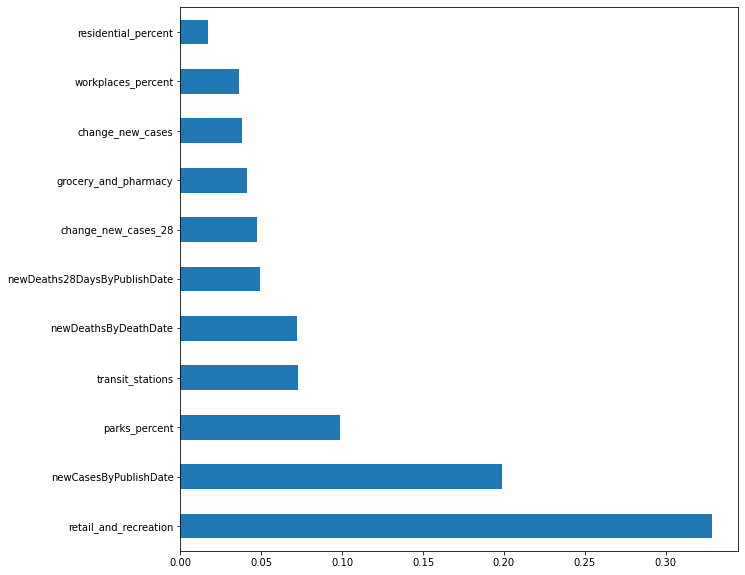

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Setting X and y variables, remove sales from the independent variable set
X = sm_df.loc[:, (sm_df.columns != 'sales')&(sm_df.columns != 'date')
              &(sm_df.columns != 'sub_region_1')&(sm_df.columns != 'country_region')
             &(sm_df.columns != 'country_region_code')]
y = sm_df['sales']
# Split into 80 / 20 training and test set
X_train = X[:int(X.shape[0]*.8)]
X_test = X[int(X.shape[0]*.8):]
y_train = y[:int(X.shape[0]*.8)]
y_test = y[int(X.shape[0]*.8):]
# Building Random Forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

## 6. Prediction - Random Forrest Regressor

In [ ]:
y_pred = model.predict(X_test)
# TODO: we can try to improve the numbers by normalising sales / covid numbers onto the same scale
#y_pred = output_scaler.inverse_transform(y_pred.reshape(-1, 1))
#y_test = output_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
len(sales_df['date'][int(sales_df.shape[0]*.8):])

54

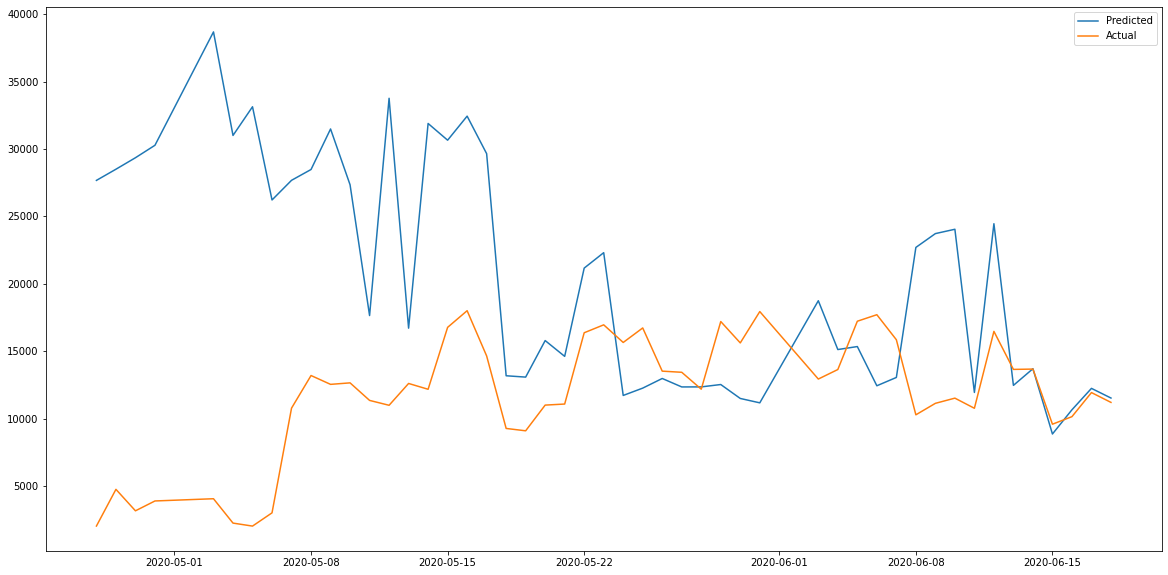

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(sm_df['date'][int(X.shape[0]*.8):], y_pred, label = 'Predicted')
plt.plot(sm_df['date'][int(X.shape[0]*.8):], y_test, label = 'Actual')
plt.legend()

## 7. Evaluate Model - Loss Function

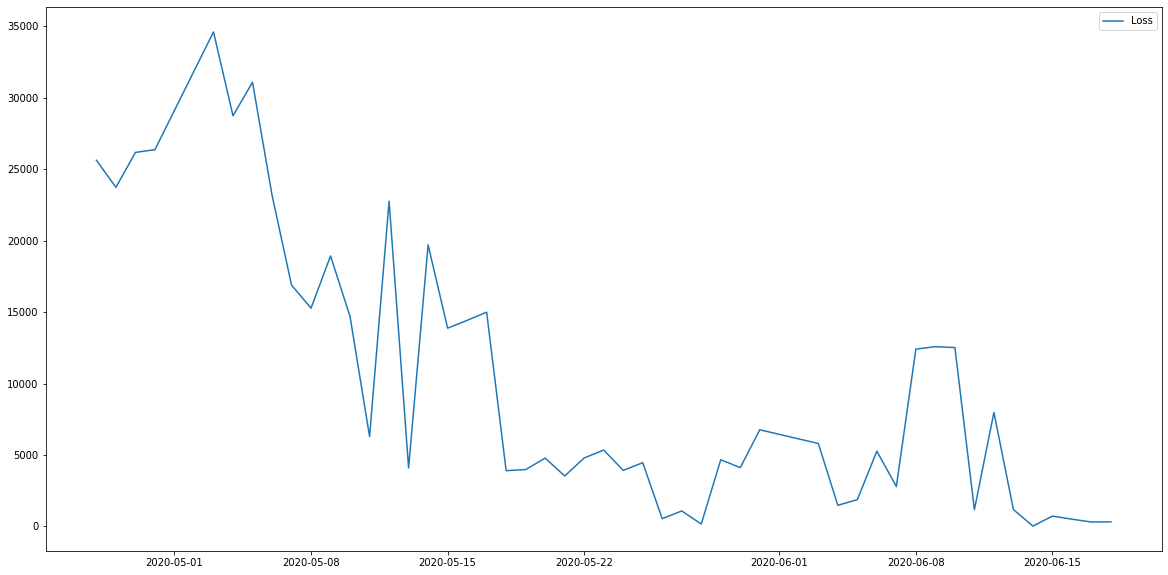

In [ ]:
plt.figure(figsize=(20, 10))
# Loss = y_test - y_pred
plt.plot(sm_df['date'][int(X.shape[0]*.8):], np.sqrt((y_test-y_pred)**2), label = 'Loss')
plt.legend()

In [ ]:
print('Primary metrics:')
print('root_mean_squared_error (RMSE) - :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r2:', metrics.r2_score(y_test, y_pred))
print('mean_squared_error(MSE):', metrics.mean_squared_error(y_test, y_pred))
print('mean_absolute_error (MAE):', metrics.mean_absolute_error(y_test, y_pred))


print('Secondary metrics:')     
print('explained_variance:', metrics.explained_variance_score(y_test, y_pred))
print('max_error:', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error:', metrics.mean_squared_log_error(y_test, y_pred))
print('mean_poisson_deviance:', metrics.mean_poisson_deviance(y_test, y_pred))
print('mean_gamma_deviance:', metrics.mean_gamma_deviance(y_test, y_pred))


Primary metrics:
root_mean_squared_error (RMSE) - : 14035.482441341912
r2: -8.692304935766066
mean_squared_error(MSE): 196994767.3612171
mean_absolute_error (MAE): 10211.010873469386
Secondary metrics:
explained_variance: -4.981947496428147
max_error: 34594.62840000002
mean_squared_log_error: 1.0875361592129615
mean_poisson_deviance: 9986.448768042137
mean_gamma_deviance: 0.6260434150148132


### Resources
- [UK Covid Download](https://coronavirus.data.gov.uk/details/download) - limited to 5 metrics only, hard to automate, not fit for purpose
- [UK Covid API](https://coronavirus.data.gov.uk/details/developers-guide) - JSON API (maybe richer than SDK below)
- [UK Covid Python SDK](https://publichealthengland.github.io/coronavirus-dashboard-api-python-sdk) - Python SDK wrapper around JSON API
- [Interactive Map](https://coronavirus.data.gov.uk/details/interactive-map) - could be potentially used for inspiration for visualisation
- [Area Code Lookup](https://data.gov.uk/dataset/7ec10db7-c8f4-4a40-8d82-8921935b4865/national-statistics-postcode-lookup-uk) - listing of UK Office of National Statistics area codes
- [ONS Area Codes](https://data.gov.uk/dataset/7ec10db7-c8f4-4a40-8d82-8921935b4865/national-statistics-postcode-lookup-uk) - listing of UK Office of National Statistics area codes